# Part 6: Convolutional Neural Networks in hls4ml

In this notebook you will learn how to train a pruned and quantized convolutional neural network (CNN) and deploy it using hls4ml. For this exercise, we will use the Street View House Numbers (SVHN) Dataset (http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of real-world images of house numbers extracted from Google Street View images. The format is similar to that of the MNIST dataset, but is a much more challenging real-world problem, as illustrated by the examples shown below.

All the images are in RGB format and have been cropped to 32x32 pixels. 
Unlike MNIST, more than one digit can be present in the same image and in these cases, the center digit is used to assign a label to the image.
Each image can belong to one of 10 classes, corresponding to digits 0 through 9.

![alt text](images/test.png "SVHN examples from the test dataset")

The SVHN dataset consists of 73,257 images for training (and 531,131 extra samples that are easier to classify and can be used as additional training data) and 26,032 images for testing.

## Start with the neccessary imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

2024-07-30 05:31:35.710508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 05:31:35.821681: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Fetch the SVHN dataset using Tensorflow Dataset

In this part we will fetch the trainining, validation and test dataset using Tensorflow Datasets (https://www.tensorflow.org/datasets). We will not use the 'extra' training in order to save time, but you could fetch it by adding `split='train[:90%]+extra'`. We will use the first 90% of the training data for training and the last 10% for validation.

2024-07-30 05:31:38.250650: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

2024-07-30 05:43:52.644143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shuffling /home/jovyan/tensorflow_datasets/svhn_cropped/3.0.0.incompleteZ2QFSW/svhn_cropped-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/svhn_cropped/3.0.0.incompleteZ2QFSW/svhn_cropped-test.tfrecord*...:…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/jovyan/tensorflow_datasets/svhn_cropped/3.0.0.incompleteZ2QFSW/svhn_cropped-extra.tfrecord*...…

Dataset svhn_cropped downloaded and prepared to /home/jovyan/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.
Training on 73257 samples of input shape (32, 32, 3), belonging to 10 classes


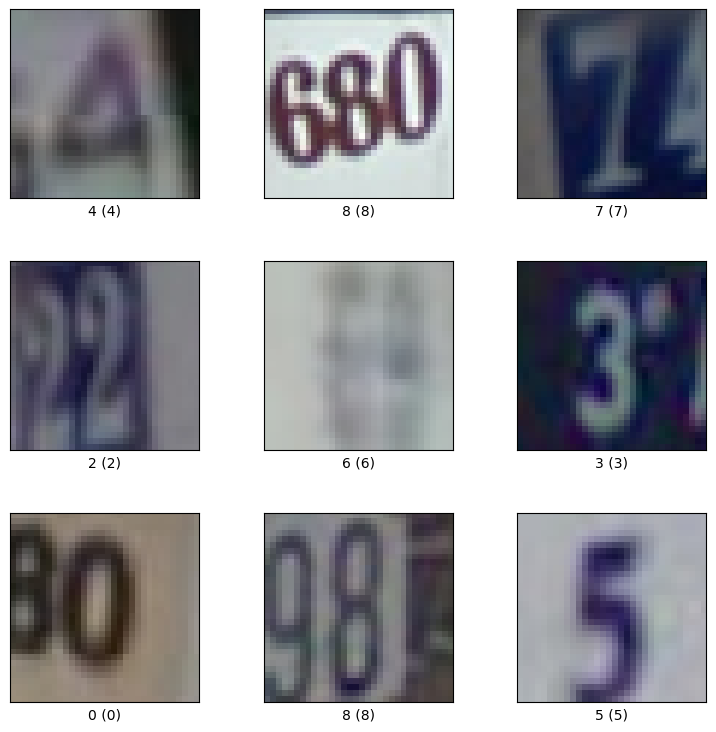

In [2]:
ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', with_info=True, as_supervised=True)
ds_test = tfds.load('svhn_cropped', split='test', shuffle_files=True, as_supervised=True)
ds_val = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size, input_shape, n_classes))
fig = tfds.show_examples(ds_train, info)

We'll use TensorFlow Dataset to prepare our datasets. We'll fetch the training dataset as tuples, and the test dataset as numpy arrays

In [3]:
def preprocess(image, label, nclasses=10):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.squeeze(label), nclasses)
    return image, label

In [4]:
batch_size = 1024

train_data = ds_train.map(preprocess, n_classes)  # Get dataset as image and one-hot encoded labels, divided by max RGB
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

# For  testing, we get the full dataset in memory as it's rather small.
# We fetch it as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('svhn_cropped', split='test', batch_size=-1, as_supervised=True))
X_test, Y_test = preprocess(X_test, Y_test, nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))

X train batch shape = (1024, 32, 32, 3), Y train batch shape = (1024, 10) 
X test batch shape = (26032, 32, 32, 3), Y test batch shape = (26032, 10) 


## Defining the model

We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 16)        432       
                                                                 
 bn_conv_0 (BatchNormalizati  (None, 30, 30, 16)       64        
 on)                                                             
                                                                 
 conv_act_0 (Activation)     (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (N

Lets check if this model can be implemented completely unrolled (=parallel)

In [6]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv_0: 432
conv_1: 2304
conv_2: 3456
dense_0: 4032
dense_1: 2688
output_dense: 640


Looks good! It's below the Vivado-enforced unroll limit of 4096.

## Prune dense and convolutional layers
Since we've seen in the previous notebooks that pruning can be done at no accuracy cost, let's prune the convolutional and dense layers to 50% sparsity, skipping the output layer

In [7]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer


model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Number of training steps per epoch is 64
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Train baseline

We're now ready to train the model! We defined the batch size and n epochs above. We won't use callbacks that store the best weights only, since this might select a weight configuration that has not yet reached 50% sparsity.

In [8]:
train = True  # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 30

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    model_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))

    model_pruned.save('pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
65/65 [==============================] - 9s 104ms/step - loss: 1.6385 - accuracy: 0.4841 - val_loss: 1.9180 - val_accuracy: 0.4611 - lr: 0.0030
Epoch 2/30
65/65 [==============================] - 7s 106ms/step - loss: 0.7961 - accuracy: 0.7880 - val_loss: 1.3834 - val_accuracy: 0.5689 - lr: 0.0030
Epoch 3/30
65/65 [==============================] - 9s 139ms/step - loss: 0.6249 - accuracy: 0.8416 - val_loss: 1.0780 - val_accuracy: 0.6765 - lr: 0.0030
Epoch 4/30
65/65 [==============================] - 9s 139ms/step - loss: 0.5496 - accuracy: 0.8641 - val_loss: 0.8152 - val_accuracy: 0.7746 - lr: 0.0030
Epoch 5/30
65/65 [==============================] - 9s 140ms/step - loss: 0.5039 - accuracy: 0.8767 - val_loss: 0.7804 - val_accuracy: 0.7815 - lr: 0.0030
Epoch 6/30
65/65 [==============================] - 9s 137ms/step - loss: 0.4719 - accuracy: 0.8840 - val_loss: 0.6623 - val_accuracy: 0.8245 - lr: 0.0030
Epoch 7/30
65/65 [==============================] - 9s 139ms/step - lo

You'll notice the accuracy is lower than that in the hls4ml CNN paper (https://arxiv.org/abs/2101.05108) despite the model being the same. The reson for this is that we didn't use the ``extra`` training data in order to save time. If you want to futher optimize the network, increasing the training data is a good place to start. Enlarging the model architecture comes at a high latency/resource cost.

## Quantization and the fused Conv2D+BatchNormalization layer in QKeras
Let's now create a pruned an quantized model using QKeras. For this, we will use a fused Convolutional and BatchNormalization (BN) layer from QKeras, which will further speed up the implementation when we implement the model using hls4ml. 
There is currently no fused Dense+BatchNoralization layer available in QKeras, so we'll use Keras BatchNormalization when BN follows a Dense layer for now. We'll use the same precision everywhere, namely a bit width of 6 and 0 integer bits (this will be implemented as``<6,1>`` in hls4ml, due to the missing sign-bit). For now, make sure to set ```use_bias=True``` in ```QConv2DBatchnorm``` to avoid problems during synthesis.

In [9]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

x = x_in = Input(shape=input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
    x = QConv2DBatchnorm(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        name='fused_convbn_{}'.format(i),
    )(x)
    x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Adding fused QConv+BN block 0 with N=16 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 fused_convbn_0 (QConv2DBatc  (None, 30, 30, 16)       513       
 hnorm)                                                          
                                                                 
 conv_act_0 (QActivation)    (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 15, 15, 16)        0         
                                                                 
 fused_convbn_1 (QConv2DBatc  (Non

In [10]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

fused_convbn_0       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
fused_convbn_2       f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_2           quantized_relu(6)
dense_0              u=42 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=64 quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)



You see that a bias quantizer is defined, although we are not using a bias term for the layers. This is set automatically by QKeras. In addition, you'll note that ``alpha='1'``. This sets the weight scale per channel to 1 (no scaling). The default is ``alpha='auto_po2'``, which sets the weight scale per channel to be a power-of-2, such that an actual hardware implementation can be performed by just shifting the result of the convolutional/dense layer to the right or left by checking the sign of the scale and then taking the log2 of the scale.

Let's now prune and train this model! If you want, you can also train the unpruned version, ``qmodel`` and see how the performance compares. We will stick to the pruned one here. Again, we do not use a model checkpoint which stores the best weights, in order to ensure the model is trained to the desired sparsity.

In [11]:
qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)

In [12]:
train = True

n_epochs = 30
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save('quantized_pruned_cnn_model.h5')

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
65/65 [==============================] - 25s 343ms/step - loss: 2.1738 - accuracy: 0.2764 - val_loss: 2.2828 - val_accuracy: 0.2329 - lr: 0.0030
Epoch 2/30
65/65 [==============================] - 24s 369ms/step - loss: 1.3882 - accuracy: 0.5812 - val_loss: 2.4530 - val_accuracy: 0.2879 - lr: 0.0030
Epoch 3/30
65/65 [==============================] - 24s 370ms/step - loss: 0.9266 - accuracy: 0.7501 - val_loss: 2.2050 - val_accuracy: 0.3934 - lr: 0.0030
Epoch 4/30
65/65 [==============================] - 24s 371ms/step - loss: 0.7450 - accuracy: 0.8040 - val_loss: 1.2675 - val_accuracy: 0.6189 - lr: 0.0030
Epoch 5/30
65/65 [==============================] - 24s 369ms/step - loss: 0.7103 - accuracy: 0.8122 - val_loss: 2.1088 - val_accuracy: 0.3640 - lr: 0.0030
Epoch 6/30
65/65 [==============================] - 24s 370ms/step - loss: 0.6559 - accuracy: 0.8262 - val_loss: 1.4988 - val_accuracy: 0.5573 - lr: 0.0030
Epoch 7/30
65/65 [==============================] - 24s 371ms/st

We note that training a model quantization aware, takes around twice as long as when not quantizing during training!
The validation accuracy is very similar to that of the floating point model equivalent, despite containing significantly less information 

## Performance
Let's look at some ROC curves to compare the performance. Lets choose a few numbers so it doesn't get confusing. Feel free to change the numbers in ``labels``.

In [13]:
predict_baseline = model_pruned.predict(X_test)
test_score_baseline = model_pruned.evaluate(X_test, Y_test)

predict_qkeras = qmodel_pruned.predict(X_test)
test_score_qkeras = qmodel_pruned.evaluate(X_test, Y_test)

print('Keras accuracy = {} , QKeras 6-bit accuracy = {}'.format(test_score_baseline[1], test_score_qkeras[1]))

814/814 [==============================] - 4s 4ms/step - loss: 0.5335 - accuracy: 0.8578
Keras accuracy = 0.8835279941558838 , QKeras 6-bit accuracy = 0.8577520251274109


Plotting ROC for labels ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


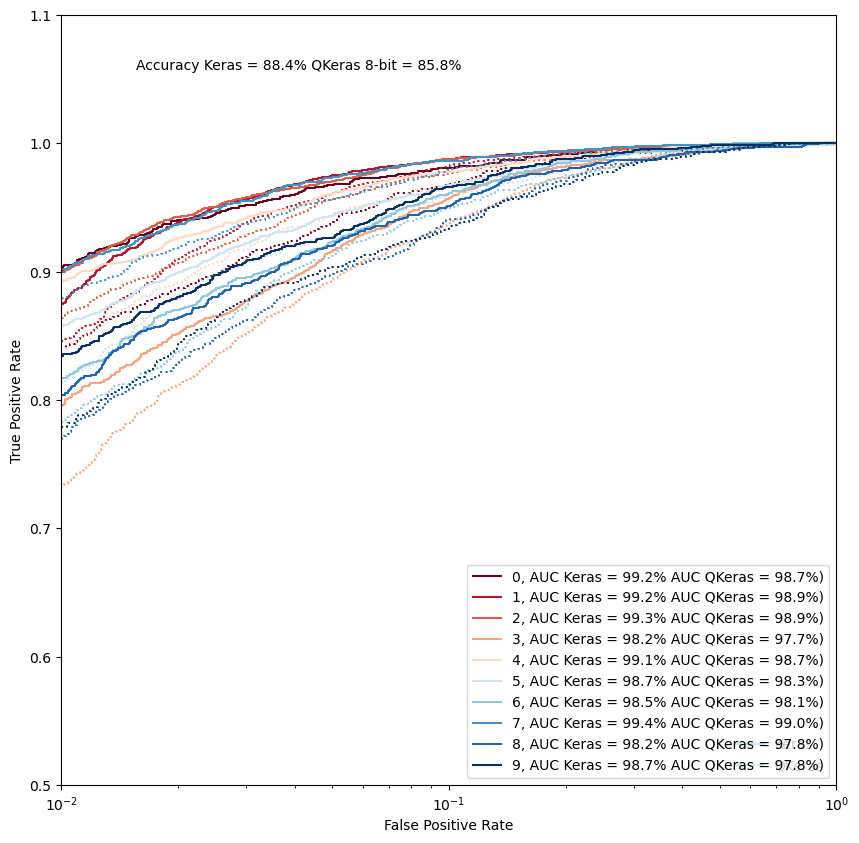

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels = ['%i' % nr for nr in range(0, n_classes)]  # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
fpr_q = {}
tpr_q = {}
auc1_q = {}
%matplotlib inline
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = Y_test[:, int(label)]
    df[label + '_pred'] = predict_baseline[:, int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label], df[label + '_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])

    df_q[label] = Y_test[:, int(label)]
    df_q[label + '_pred'] = predict_qkeras[:, int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label], df_q[label + '_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])

    plt.plot(
        fpr[label],
        tpr[label],
        label=r'{}, AUC Keras = {:.1f}% AUC QKeras = {:.1f}%)'.format(label, auc1[label] * 100, auc1_q[label] * 100),
        linewidth=1.5,
        c=colors[i],
        linestyle='solid',
    )
    plt.plot(fpr_q[label], tpr_q[label], linewidth=1.5, c=colors[i], linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01, 1.0)
plt.ylim(0.5, 1.1)
plt.legend(loc='lower right')
plt.figtext(
    0.2,
    0.83,
    r'Accuracy Keras = {:.1f}% QKeras 8-bit = {:.1f}%'.format(test_score_baseline[1] * 100, test_score_qkeras[1] * 100),
    wrap=True,
    horizontalalignment='left',
    verticalalignment='center',
)
from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras', 'QKeras'], loc='lower right', frameon=False)
ax.add_artist(leg)

The difference in AUC between the fp32 Keras model and the 8-bit QKeras model, is small, as we have seen for the previous examples. You can find a bonus exercise below, **Bonus: Automatic quantization**, where we'll use AutoQKeras to find the best heterogeneously quantized model, given a set of resource and accuracy constriants.
### Check sparsity
Let's also check the per-layer sparsity:

Layer prune_low_magnitude_conv_0: % of zeros = 0.5
Layer bn_conv_0: % of zeros = 0.0
Layer prune_low_magnitude_conv_1: % of zeros = 0.5
Layer bn_conv_1: % of zeros = 0.0
Layer prune_low_magnitude_conv_2: % of zeros = 0.5
Layer bn_conv_2: % of zeros = 0.0
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0
Layer prune_low_magnitude_fused_convbn_0: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_1: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_2: % of zeros = 0.5
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer prune_low_magnitude_dense_1: % of zeros = 0.5
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


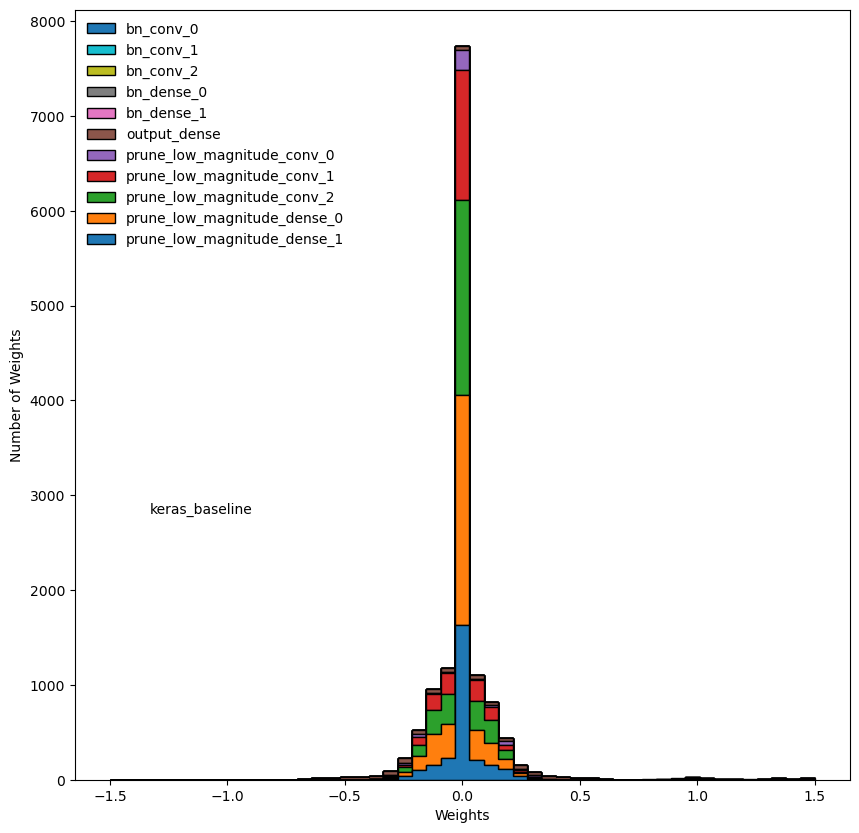

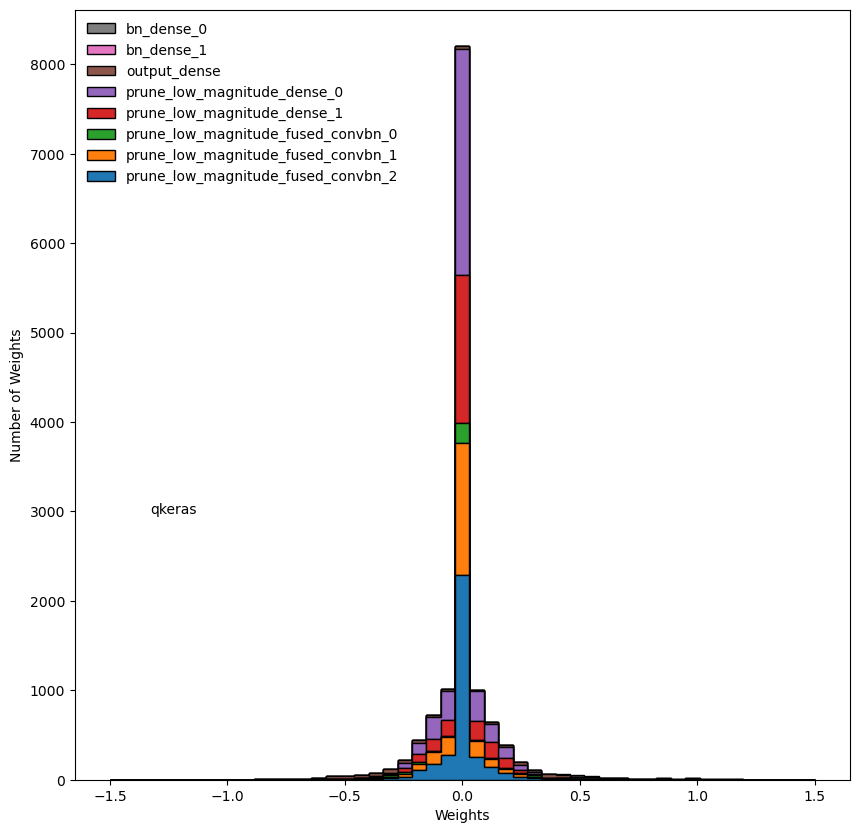

In [15]:
def doWeights(model):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, model._name, wrap=True, horizontalalignment='left', verticalalignment='center')


doWeights(model_pruned)
doWeights(qmodel_pruned)

We see that 50% of the weights per layer are set to zero, as expected.
Now, let's synthesize the floating point Keras model and the QKeras quantized model!

## CNNs in hls4ml

In this part, we will take the two models we trained above (the floating-point 32 Keras model and the 6-bit QKeras model), and synthesize them with hls4ml. Although your models are probably already in memory, let's load them from scratch. We need to pass the appropriate custom QKeras/pruning layers when loading, and remove the pruning parameters that were saved together with the model.

In [16]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)
model = strip_pruning(model)

qmodel = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)
qmodel = strip_pruning(qmodel)

Now, we need to define the hls4ml and Vivado configurations. Two things will change with respect to what was done in the previous exercises. First, we will use ``IOType= 'io_stream'`` in the Vivado configuration.

---
****You must use ``IOType= 'io_stream'`` if attempting to synthesize a large convolutional neural network.****

---
The CNN implementation in hls4ml is based on streams, which are synthesized in hardware as first in, first out (FIFO) buffers. Shift registers are used to keep track of the last  ``<kernel height - 1>`` rows of input pixels, and maintains a shifting snapshot of the convolution kernel.

This is illustrated  in the gif below. Here, the input image is at the top-left and the output image at the bottom left. The top right image shows the internal state of the shift registers and convolutional kernel. The red square indicates the current pixels contained within the convolutional kernel.

![alt text](images/conv2d_animation.gif "The implementation of convolutional layers in hls4ml.")

Lastly, we will use ``['Strategy'] = 'Latency'`` for all the layers in the hls4ml configuration. If one layer would have >4096 elements, we sould set ``['Strategy'] = 'Resource'`` for that layer, or increase the reuse factor by hand. You can find examples of how to do this below.

In [17]:
import hls4ml
import plotting

# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource'
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
# If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'pruned_cnn/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D,

Done


Let's get a nice overview over the various shapes and precisions used for each layer through ``hls4ml.utils.plot_model``, as well as look at the weight profile using ``hls4ml.model.profiling.numerical``. The weight profiling returns two plots: Before (top) and after (bottom) various optimizations applied to the HLS model before the final translation to HLS, for instance the fusing of Dense and BatchNormalization layers.

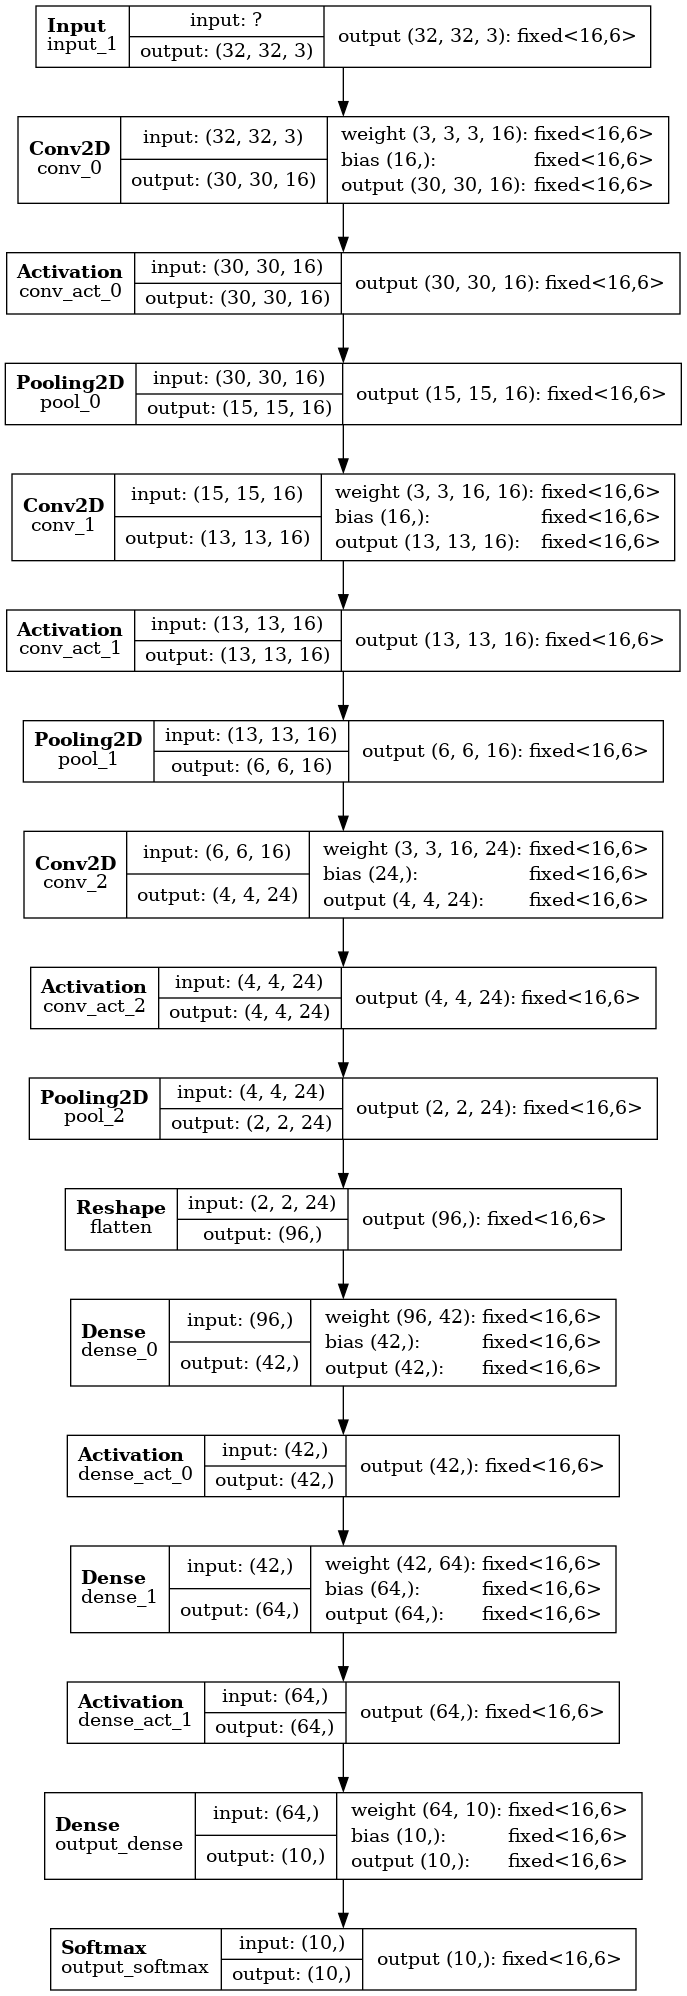

In [18]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D,

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

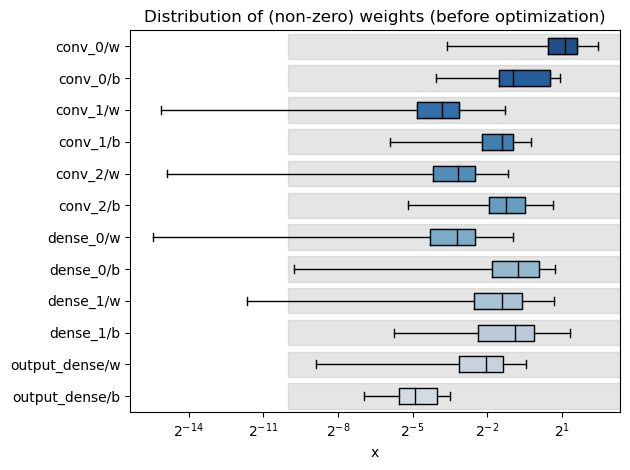

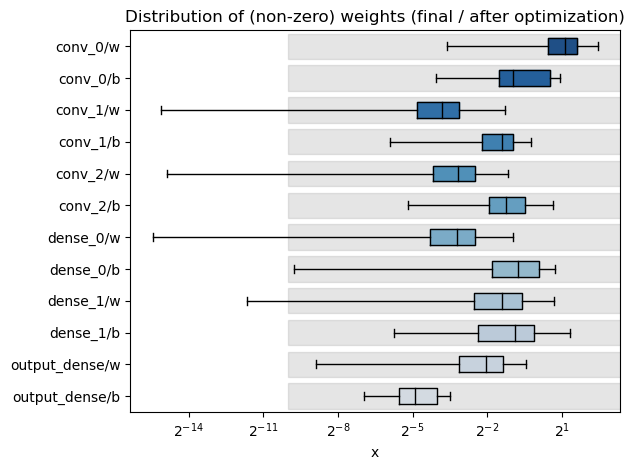

In [19]:
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model)

The colored boxes are the distribution of the weights of the model, and the gray band illustrates the numerical range covered by the chosen fixed point precision. As we configured, this model uses a precision of ``ap_fixed<16,6>`` for all layers of the model. Let's now build our QKeras model

In [20]:
# Then the QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 1
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_q)

cfg_q = hls4ml.converters.create_config(backend='Vivado')
cfg_q['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_q['HLSConfig'] = hls_config_q
cfg_q['KerasModel'] = qmodel
cfg_q['OutputDir'] = 'quantized_pruned_cnn/'
cfg_q['XilinxPart'] = 'xcu250-figd2104-2L-e'

hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 6, 6, 16]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 6, 6, 16]], output shape: [None, 4, 4, 24]
Layer name: conv_act_

Done


Let's plot the model and profile the weights her too

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 32, 32, 3]], output shape: [None, 32, 32, 3]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 32, 32, 3]], output shape: [None, 30, 30, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 30, 30, 16]], output shape: [None, 30, 30, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 16]], output shape: [None, 15, 15, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 15, 15, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 13, 13, 16]], output shape: [None, 13, 13, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 6, 6, 16]
Layer name: fused_convbn_2, layer type: QConv2DBatchnorm, input shapes: [[None, 6, 6, 16]], output shape: [None, 4, 4, 24]
Layer name: conv_act_

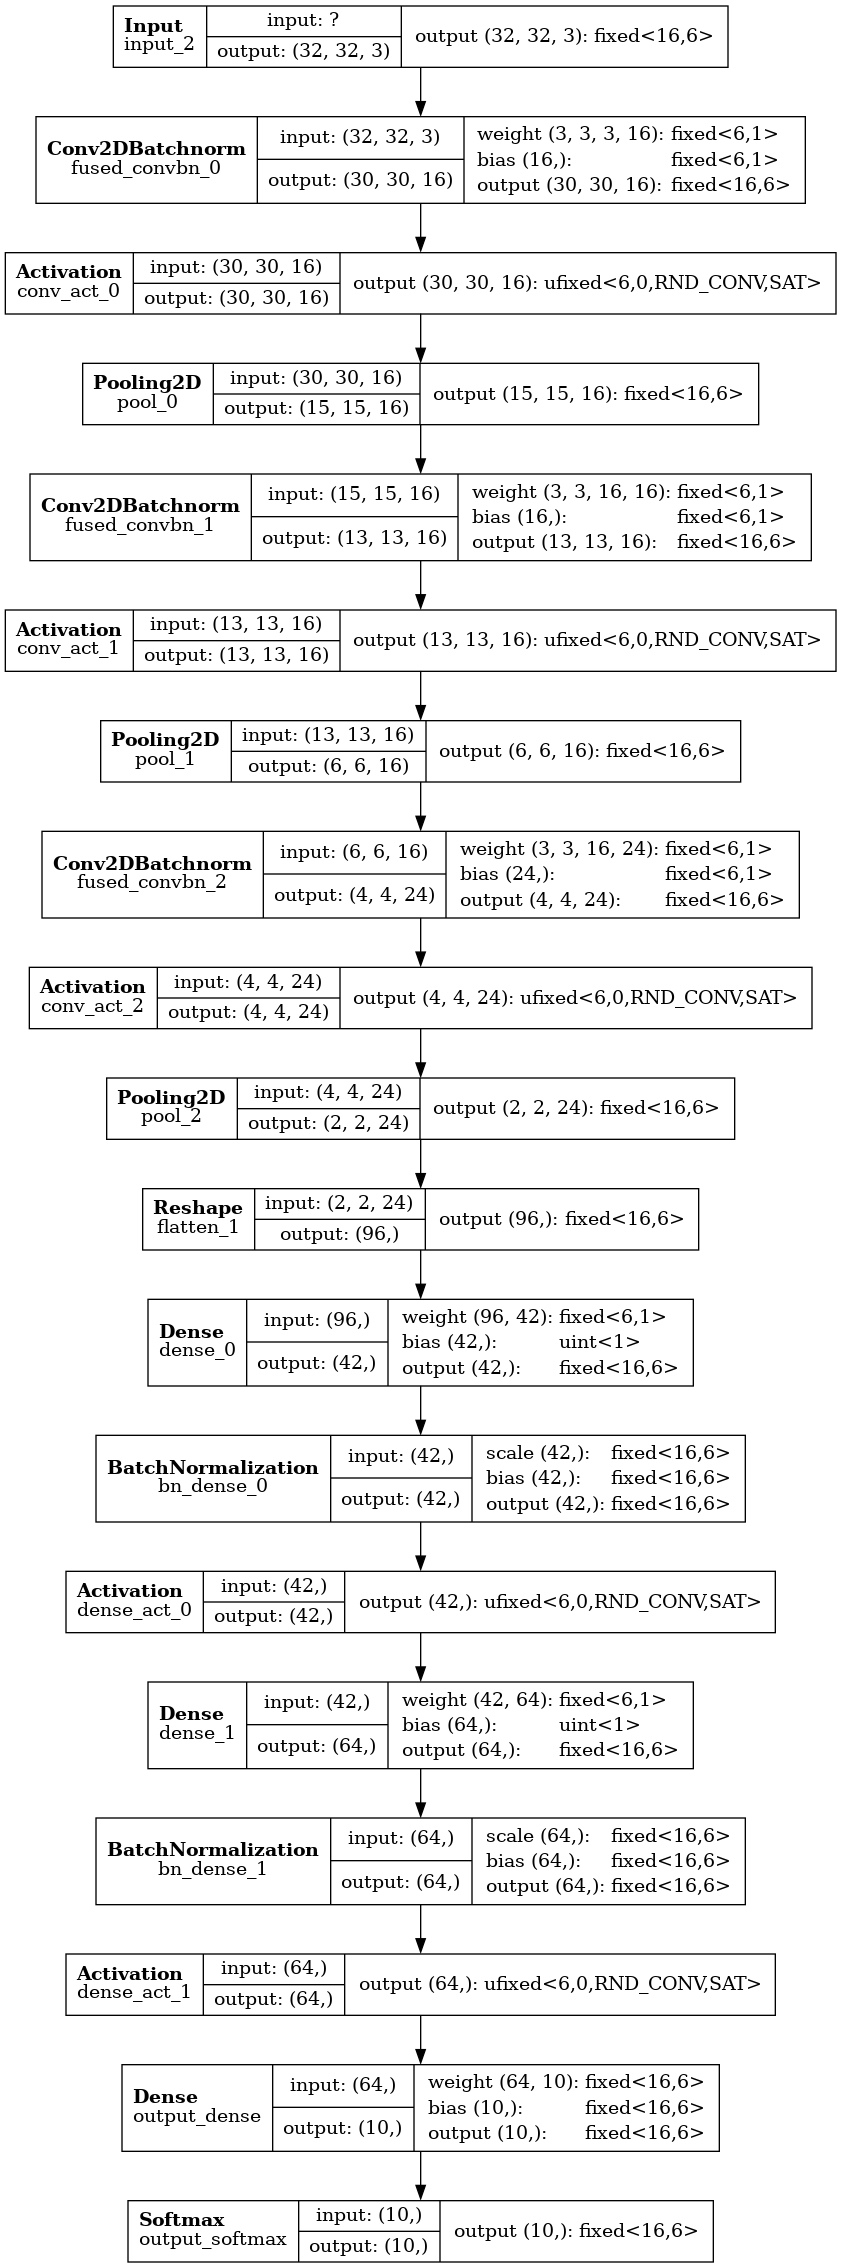

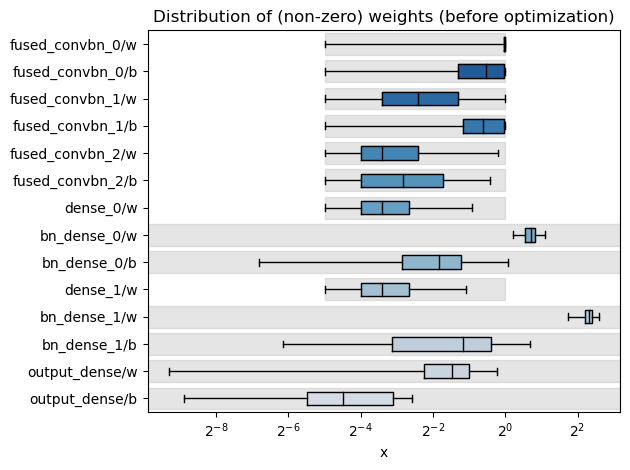

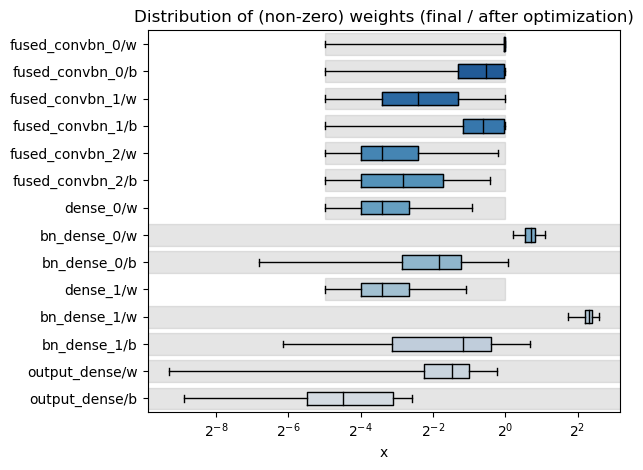

In [21]:
hls4ml.model.profiling.numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

For the 6-bit QKeras model, we see that different precisions are used for different layers.

### Accuracy with bit-accurate emulation 
Let's check that the hls4ml accuracy matches the original. This usually takes some time, so let's do it over a reduced dataset

In [22]:
X_test_reduced = X_test[:3000]
Y_test_reduced = Y_test[:3000]

In [23]:
y_predict = model.predict(X_test_reduced)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(X_test_reduced))

94/94 [==============================] - 0s 2ms/step


In [24]:
y_predict_q = qmodel.predict(X_test_reduced)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(X_test_reduced))

94/94 [==============================] - 1s 5ms/step


Accuracy Keras:  0.8843333333333333
Accuracy hls4ml: 0.885
Accuracy Keras:  0.8576666666666667
Accuracy hls4ml: 0.8586666666666667


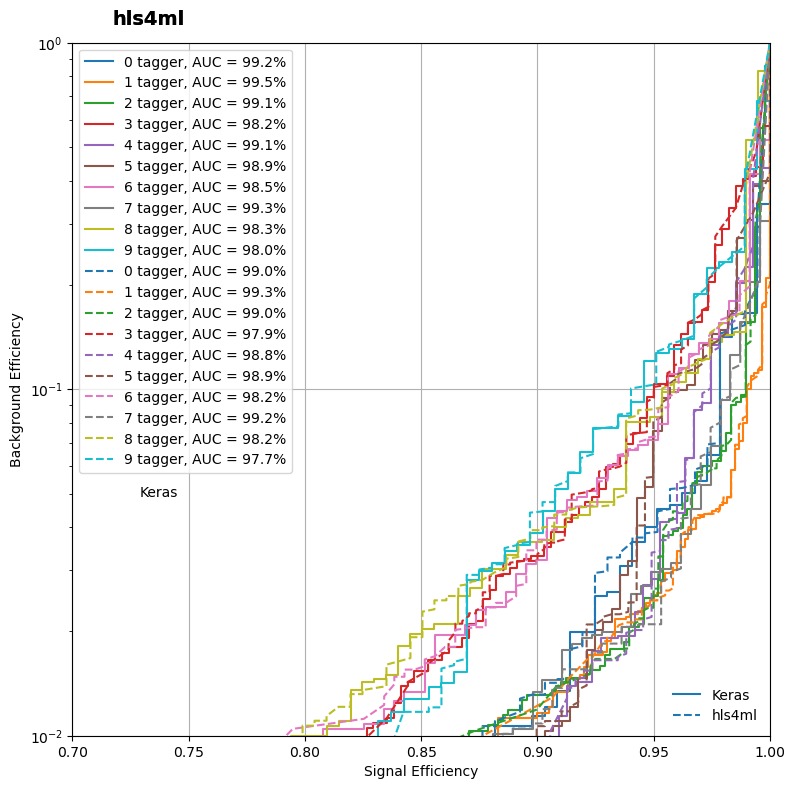

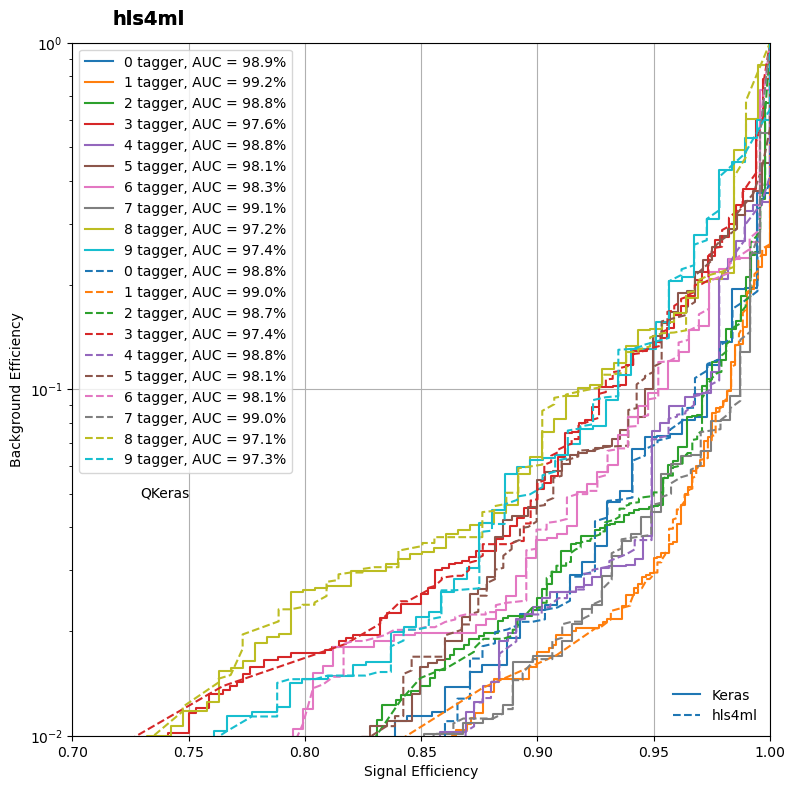

In [25]:
import plotting
from sklearn.metrics import accuracy_score


def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    accuracy_keras = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred, axis=1)))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred_hls4ml, axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))

    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i' % nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None)  # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i' % nr for nr in range(n_classes)], linestyle='--')

    from matplotlib.lines import Line2D

    lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend

    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'], loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38, label, wrap=True, horizontalalignment='left', verticalalignment='center')
    plt.ylim(0.01, 1.0)
    plt.xlim(0.7, 1.0)


# Plot the pruned floating point model:
plotROC(Y_test_reduced, y_predict, y_predict_hls4ml, label="Keras")

# Plot the pruned and quantized QKeras model
plotROC(Y_test_reduced, y_predict_q, y_predict_hls4ml_q, label="QKeras")

Looks good! Let's synthesize the models. 
## Logic synthesis
This takes quite a while for CNN models, up to one hour for the models considered here. In the interest of time, we have therefore provided the neccessary reports for the models considered. You can also synthesize them yourself if you have time, and as usual follow the progress using ``tail -f pruned_cnn/vivado_hls.log`` and ``tail -f quantized_pruned_cnn/vivado_hls.log``.


In [26]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

synth = False  # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model.build(csim=False, synth=True, vsynth=True)
    hls_model_q.build(csim=False, synth=True, vsynth=True)

We extract the latency from the C synthesis, namely the report in ```<project_dir>/myproject_prj/solution1/syn/report/myproject_csynth.rpt```. A more accurate latency estimate can be obtained from running cosim by passing ```hls_model.build(csim=False, synth=True, vsynth=True, cosim=True)``` ( = C/RTL cosimulation, synthesised HLS code is run on a simulator and tested on C test bench) but this takes a lot of time so we will skip it here.
The resource estimates are obtained from the Vivado logic synthesis, and can be extracted from the report in ```<project_dir>/vivado_synth.rpt```. Let's fetch the most relevant numbers:

In [27]:
def getReports(indir):
    data_ = {}

    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))

    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))

        # Get the resources from the logic synthesis report
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut'] = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff'] = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp'] = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel'] = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])

        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus'] = float(lat_line.split('|')[2]) * 5.0 / 1000.0
            data_['latency_ii'] = int(lat_line.split('|')[6])

    return data_

In [28]:
from pathlib import Path
import pprint

data_pruned_ref = getReports('pruned_cnn')
data_quantized_pruned = getReports('quantized_pruned_cnn')

print("\n Resource usage and latency: Pruned")
pprint.pprint(data_pruned_ref)
print("\n Resource usage and latency: Pruned + quantized")
pprint.pprint(data_quantized_pruned)

Found valid vsynth and synth in pruned_cnn! Fetching numbers
Found valid vsynth and synth in quantized_pruned_cnn! Fetching numbers

 Resource usage and latency: Pruned
{'bram': 42.0,
 'bram_rel': 1.56,
 'dsp': 5386,
 'dsp_rel': 43.83,
 'ff': 43435,
 'ff_rel': 1.26,
 'latency_clks': 1044,
 'latency_ii': 1028,
 'latency_mus': 5.22,
 'lut': 123948,
 'lut_rel': 7.17}

 Resource usage and latency: Pruned + quantized
{'bram': 34.0,
 'bram_rel': 1.26,
 'dsp': 353,
 'dsp_rel': 2.87,
 'ff': 30702,
 'ff_rel': 0.89,
 'latency_clks': 1044,
 'latency_ii': 1028,
 'latency_mus': 5.22,
 'lut': 118931,
 'lut_rel': 6.88}


We see that the latency is of around 5 microseconds for both the quantized and the unquantized model, but that the resources are signifcantly reduced using QKeras.

Congratulations! You have now reached the end of this notebook. If you have some spare time, you can have a look at the bonus exercise below, where you will learn how to perform a bayesian optimization over the QKeras quantizers in order to obtain an optimally heterogeneously quantized model.












## Bonus exercise: Automatic quantization with AutoQKeras

In this bonus exercise, you will learn how to find the optimal heterogeneously quantized model using AutoQKeras.
For more details, you can look at the [AutoQKeras notebook](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb). 

Let's first check the estimated energy consumption of the QKeras 6-bit model using QTools. By setting ```for_reference=True``` you can print out the unquantized model energy consumption and compare the two. Note that this only works for QKeras layers. 

In [29]:
filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

baseline_model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

baseline_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons


In [30]:
from qkeras import print_qstats

# for automatic quantization
import pprint
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize

from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras import quantized_bits
from qkeras import QDense, QActivation

q = run_qtools.QTools(
    baseline_model,
    process="horowitz",
    source_quantizers=[quantized_bits(16, 5, 1)],
    is_inference=True,
    weights_path=None,
    keras_quantizer="fp16",
    keras_accumulator="fp16",
    for_reference=False,
)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed", activations_on_memory="fixed", min_sram_size=8 * 16 * 1024 * 1024, rd_wr_on_io=False
)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


{
    "source_quantizers": [
        {
            "quantizer_type": "quantized_bits",
            "bits": 16,
            "int_bits": 6,
            "is_signed": true
        }
    ],
    "conv_0": {
        "layer_type": "Conv2D",
        "input_quantizer_list": [
            {
                "quantizer_type": "quantized_bits",
                "bits": 16,
                "int_bits": 6,
                "is_signed": true
            }
        ],
        "weight_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": [
                3,
                3,
                3,
                16
            ]
        },
        "multiplier": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "op_type": "mul"
        },
        "accumulator": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "op_type": "add"
        },
        "output_quantizer": {
            "quantiz

Now, lets use AutoQKeras to find an optimally heterogeneously quantized model for us. For more details, check the AutoQKeras tutorial linked above. As baseline model, we'll use the pruned floating point Keras model from above.

In [31]:
# These are the quantizers we'll test in the bayesian optimization
quantization_config = {
    "kernel": {
        "quantized_bits(2,0,1,alpha=1.0)": 2,
        "quantized_bits(4,0,1,alpha=1.0)": 4,
        "quantized_bits(6,0,1,alpha=1.0)": 6,
        "quantized_bits(8,0,1,alpha=1.0)": 8,
    },
    "bias": {
        "quantized_bits(2,0,1,alpha=1.0)": 2,
        "quantized_bits(4,0,1,alpha=1.0)": 4,
        "quantized_bits(6,0,1,alpha=1.0)": 6,
        "quantized_bits(8,0,1,alpha=1.0)": 8,
    },
    "activation": {
        "quantized_relu(3,1)": 3,
        "quantized_relu(4,2)": 4,
        "quantized_relu(8,2)": 8,
        "quantized_relu(8,4)": 8,
        "quantized_relu(16,6)": 16,
    },
    "linear": {
        "quantized_bits(2,0,1,alpha=1.0)": 2,
        "quantized_bits(4,0,1,alpha=1.0)": 4,
        "quantized_bits(6,0,1,alpha=1.0)": 6,
        "quantized_bits(8,0,1,alpha=1.0)": 8,
    },
}

# These are the layer types we will quantize
limit = {
    "Dense": [8, 8, 16],
    "Conv2D": [8, 8, 16],
    "Activation": [16],
}

# Use this if you want to minimize the model bit size
goal_bits = {
    "type": "bits",
    "params": {
        "delta_p": 8.0,  # We tolerate up to a +8% accuracy change
        "delta_n": 8.0,  # We tolerate down to a -8% accuracy change
        "rate": 2.0,  # We want a x2 times smaller model
        "stress": 1.0,  # Force the reference model size to be smaller by setting stress<1
        "input_bits": 8,
        "output_bits": 8,
        "ref_bits": 8,
        "config": {"default": ["parameters", "activations"]},
    },
}

# Use this if you want to minimize the model energy consumption
goal_energy = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["fp32"],
        "reference_internal": "int8",
        "reference_accumulator": "int32",
    },
}

run_config = {
    "goal": goal_energy,
    "quantization_config": quantization_config,
    "learning_rate_optimizer": False,
    "transfer_weights": False,  # Randomely initialize weights
    "mode": "bayesian",  # This can be bayesian,random,hyperband
    "seed": 42,
    "limit": limit,
    "tune_filters": "layer",
    "tune_filters_exceptions": "^output",
    "distribution_strategy": None,
    "max_trials": 5,  # Let's just do 5 trials for this demonstrator, ideally you should do as many as possible
}

In [33]:
from qkeras.autoqkeras import AutoQKeras

autoqk = AutoQKeras(baseline_model, output_dir="autoq_cnn", metrics=["acc"], custom_objects={}, **run_config)
autoqk.fit(train_data, validation_data=val_data, epochs=15)

aqmodel = autoqk.get_best_model()
print_qmodel_summary(aqmodel)

# Train for the full epochs
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
]

start = time.time()
history = aqmodel.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
end = time.time()
print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

Trial 2 Complete [00h 00m 01s]

Best val_score So Far: None
Total elapsed time: 00h 00m 02s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
quantized_bits(...|quantized_bits(...|conv_0_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv_1_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv_2_kernel_quantizer
quantized_bits(...|quantized_bits(...|dense_0_kernel_quantizer
quantized_bits(...|quantized_bits(...|dense_1_kernel_quantizer
quantized_bits(...|quantized_bits(...|output_dense_kernel_quantizer
0.5               |1                 |network_filters_conv_0
quantized_relu(...|quantized_relu(...|conv_act_0_activation_quantizer
1.5               |1                 |network_filters_conv_1
quantized_relu(...|quantized_relu(...|conv_act_1_activation_quantizer
1.5               |2                 |network_filters_conv_2
quantized_relu(...|quantized_relu(...|conv_act_2_activation_quantizer
0.75              |2                 |network_filters_d

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in er

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__autograph_generated_filegbzni5th.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
tensorflow.python.autograph.pyct.error_utils.MultilineMessageKeyError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
        self.apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1213, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 216, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable conv_0/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'



In [ ]:
# This model has some remnants from the optimization procedure attached to it, so let's define a new one
aqmodel.save_weights("autoqkeras_cnn_weights.h5")

layers = [l for l in aqmodel.layers]
x = layers[0].output
for i in range(1, len(layers)):
    x = layers[i](x)

new_model = Model(inputs=[layers[0].input], outputs=[x])
LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

new_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
new_model.summary()
new_model.load_weights("autoqkeras_cnn_weights.h5")
print_qmodel_summary(new_model)

Let's check what the best heterogeneously quantized model looks like (keep in mind we only did a few trials, the optimization obviosuly didn't have time to converge at the minimum but yo get the idea!)

In [ ]:
hls_config_aq = hls4ml.utils.config_from_keras_model(new_model, granularity='name')
hls_config_aq['Model']['ReuseFactor'] = 1
hls_config_aq['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_aq['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_aq)

cfg_aq = hls4ml.converters.create_config(backend='Vivado')
cfg_aq['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_aq['HLSConfig'] = hls_config_aq
cfg_aq['KerasModel'] = new_model
cfg_aq['OutputDir'] = 'autoqkeras_cnn/'
cfg_aq['XilinxPart'] = 'xcu250-figd2104-2L-e'

hls_model_aq = hls4ml.converters.keras_to_hls(cfg_aq)
hls_model_aq.compile()

In [ ]:
y_predict_aq = aqmodel.predict(X_test_reduced)
y_predict_hls4ml_aq = hls_model_aq.predict(np.ascontiguousarray(X_test_reduced))


accuracy_keras = float(accuracy_score(np.argmax(Y_test_reduced, axis=1), np.argmax(y_predict_aq, axis=1)))
accuracy_hls4ml = float(accuracy_score(np.argmax(Y_test_reduced, axis=1), np.argmax(y_predict_hls4ml_aq, axis=1)))

print("Accuracy AutoQ Keras:  {}".format(accuracy_keras))
print("Accuracy AutoQ hls4ml: {}".format(accuracy_hls4ml))

The accuracy is slightly lower for this heterogeneously quantized model. Due to some randomness in the optimization procedure, you're going to have to synthesize this one yourself!

In [ ]:
synth = True
if synth:
    hls_model_aq.build(csim=False, synth=True, vsynth=True)
    data_autoq = getReports('autoq_cnn')

    print("\n Resource usage and latency: AutoQ")
    pprint.pprint(data_autoq)